# Случайные процессы. Прикладной поток.
## Практическое задание 6

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 6"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `6.N.ipynb` и `6.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* При проверке могут быть запущены функции, которые отвечают за генерацию траекторий винеровского процесса.

------------------

In [1]:
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
%matplotlib inline

### 1. Генерация винеровского процесса

Генерировать траектории винеровского процесса можно двумя способами:

1. На отрезке $[0, 1]$ траектория генерируется с помощью функций Шаудера. Описание данного метода было рассказано на лекции. Его можно найти так же в книге *А.В. Булинский, А.Н. Ширяев - Теория случайных процессов*.

2. На отрезке $[0, \pi]$ траекторию можно с помощью следующей формулы
$$W_t = \frac{\xi_0 t}{\sqrt{\pi}} +\sqrt{\frac{2}{\pi}}\sum\limits_{i=1}^{+\infty} \frac{\sin(kt)}{k} \xi_k,$$
где $\{\xi_n\}$ --- независимые стандартные нормальные случайные величины.

Траектория для $\mathbb{R}_+$ генерируется с помощью генерирования отдельных траекторий для отрезков длины 1 или $\pi$ (в зависимости от метода) с последующим непрерывным склеиванием.

Генерацию траекторий одним из этих способов вам нужно реализовать. Ваш вариант можете узнать из файла с распределением.

Напишите класс, который будет моделировать винеровский процесс.
Из бесконечной суммы берите первые $n$ слагаемых, где число $n$ соответствует параметру `precision`.
Интерфейс должен быть примерно таким (подчеркивания обязательны!):

In [3]:
class WinerProcess:
    def __init__(self, precision=10000):
        self.precision = precision
        self.xi = [sps.norm.rvs(size=precision)]
        self.n = np.log2(np.arange(1, precision)).astype(int)
        self.power = np.power(2, self.n)
        self.powerp1 = np.power(2, self.n + 1)
        self.powerhalf = np.power(2, self.n / 2 + 1)
        self.a_nk = (np.arange(1, precision) - self.power) / self.power
        
    def __getitem__(self, times):
        W = np.array([])
        last_time = np.max(times)
        if (last_time - int(last_time) > 0):
            last_time = int(last_time) + 1
        else:
            last_time = last_time.astype(int) + 1
        y = sps.norm.rvs(size=(last_time - len(self.xi), self.precision))
        self.xi += list(y)
        self.rights = np.cumsum(np.array(self.xi)[:,0])
        for i in range(len(times)):
            integer = int(times[i])
            fraction = times[i] - int(times[i])
            S = np.zeros(self.precision - 1)
            positive_slope = np.logical_and(fraction <= (self.a_nk + (1 / self.powerp1)),
                                            self.a_nk <= fraction)
            negative_slope = np.logical_and(fraction <= (self.a_nk + (1 / self.power)),
                                            (self.a_nk + (1 / self.powerp1)) < fraction)
            S[positive_slope] = ((fraction - self.a_nk[positive_slope]) * self.powerp1[positive_slope]) /\
                                 self.powerhalf[positive_slope]
            S[negative_slope] = (self.a_nk[negative_slope] + (1 / self.power[negative_slope]) - fraction)/\
                                ((1 / self.powerp1[negative_slope]) * self.powerhalf[negative_slope])
            S = np.insert(S, 0, fraction)
            if (integer > 0):
                W = np.append(W, self.rights[integer - 1] + S @ self.xi[integer].T)
            else:
                W = np.append(W, S @ self.xi[integer].T)
        return W

* Экземпляр класса должен представлять некоторую траекторию винеровского процесса. Это означает, что один и тот же экземпляр класса для одного и того же момента времени должен возвращать одно и тоже значение. Разные экземпляры класса --- разные (п.н.) траектории.

* Метод `__init__` (конструктор) должен запоминать число слагаемых в сумме (`precision`), а также (может быть) генерировать необходимые случайные величины для начального отрезка.

* Метод `__getitem__` должен принимать набор моментов времени и возвращать значения траектории винеровского процесса в эти моменты времени. При необходимости можно сгенерировать новые случайные величины. Используйте то, что запись `x.__getitem__(y)` эквивалентна `x[y]`.

* Для получения полного балла и быстро работающего кода реализация должна содержать не более одного явного цикла (по отрезкам при непосредственной генерации). Вместо всех остальных циклов нужно использовать функции библиотеки `numpy`.

* Внимательно проверьте отсутствие разрывов траектории в точках, кратных $\pi$.

* Имена любых вспомогательных методов должны начинаться с одного подчеркивания.

* В реализации желательно комментировать (почти) каждую строку кода. Это даже больше поможет вам, чем нам при проверке.

Сгенерируйте траекторию винеровского процесса и постройте ее график. Сгенерируйте еще одну траекторию и постройте график двумерного винеровского процесса. Графики должны быть похожими на графики с семинара.

In [20]:
p = WinerProcess()
f = WinerProcess()

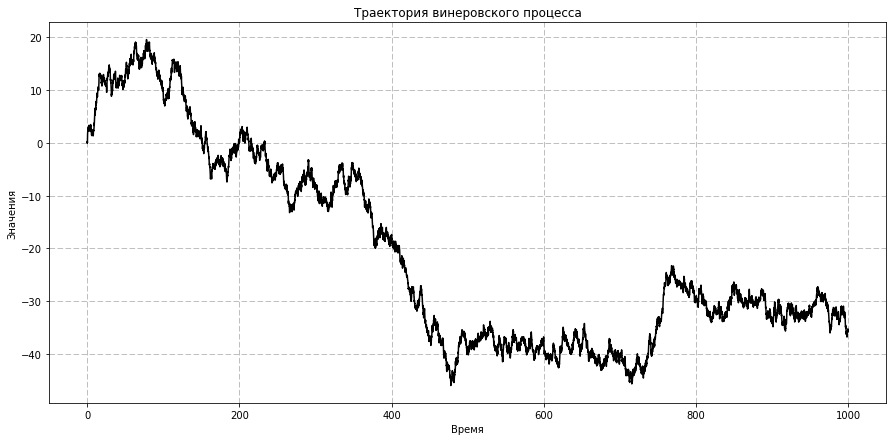

In [21]:
plt.figure(figsize=(15,7))

t = np.linspace(0., 1000., 10000)

plt.plot(t, p[t], c='black')

plt.title('Траектория винеровского процесса')
plt.ylabel('Значения')
plt.xlabel('Время')
plt.grid(ls='--')
plt.show()

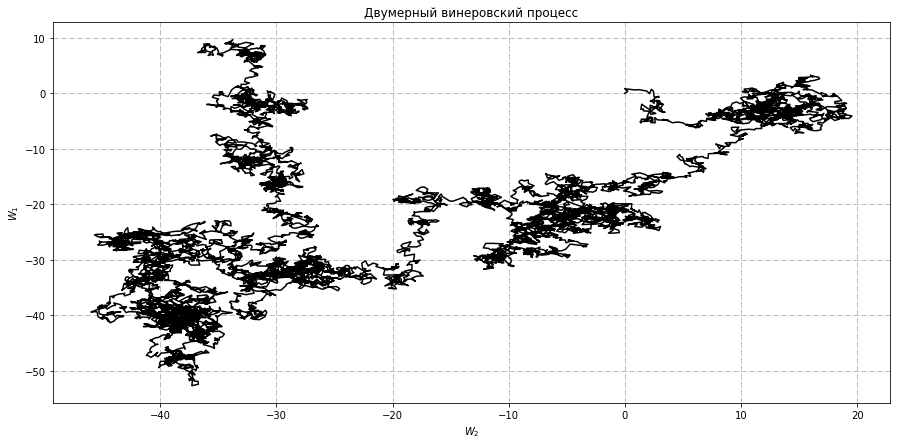

In [22]:
plt.figure(figsize=(15,7))

t = np.linspace(0., 1000., 10000)

plt.plot(p[t], f[t], c='black')

plt.title('Двумерный винеровский процесс')
plt.ylabel(r'$W_{1}$')
plt.xlabel(r'$W_{2}$')
plt.grid(ls='--')
plt.show()

Допустим, для исследования свойств траекторий винеровского процесса нам нужно сгенерировать траекторию с хорошей точностью до достаточно большого значения $t$.
Какие проблемы могут возникнуть при использовании реализованного класса?
Для этого попробуйте запустить следующий код.

In [23]:
Wt = WinerProcess()
t = np.linspace(0, 10 ** 7, 10 ** 5)
values = Wt[t]

MemoryError: 

Опишите подробно причину проблемы, которая в данном случае возникает.

...

Для избавления от таких проблем реализуйте следующую функцию:

In [30]:
def winer_proccess_path(end_time, step, precision=10000):
    # Моменты времени, в которые нужно вычислить значения
    times = np.arange(0, end_time, step)
    # Сюда запишите значения траектории в моменты времени times
    values = np.zeros_like(times)
    
    xi_0 = sps.norm.rvs(size=int(end_time) + 1)
    cumsum = np.cumsum(xi_0)
    n = np.log2(np.arange(1, precision)).astype(int)
    power = np.power(2, n)
    powerp1 = np.power(2, n + 1)
    powerhalf = np.power(2, n / 2 + 1)
    rpower = 1 / np.power(2, n)
    rpowerp1 = 1 / np.power(2, n + 1)
    a_nk = (np.arange(1, precision) - power) / power
    lastinteger = 0
    eta = sps.norm.rvs(size=precision - 1)
    for i in range(len(times)):
        integer = int(times[i])
        fraction = times[i] - int(times[i])
        if (integer > lastinteger):
            xi = sps.norm.rvs(size=precision - 1)
            eta = xi
            lastinteger = integer
        else:
            xi = eta
        S = np.zeros(precision - 1)
        positive_slope = np.logical_and(fraction <= (a_nk + rpowerp1), a_nk <= fraction)
        negative_slope = np.logical_and(fraction <= (a_nk + rpower), (a_nk + rpowerp1) < fraction)
        S[positive_slope] = ((fraction - a_nk[positive_slope]) * powerp1[positive_slope]) / powerhalf[positive_slope]
        S[negative_slope] = (a_nk[negative_slope] + rpower[negative_slope] - fraction)/\
                            (rpowerp1[negative_slope] * powerhalf[negative_slope])
        if (integer > 0):
            values[i] = cumsum[integer - 1] + S @ xi.T + fraction * xi_0[integer]
        else:
            values[i] = S @ xi.T + fraction * xi_0[integer]
    return times, values

Для получения полного балла и быстро работающего кода реализация должна содержать не более одного явного цикла (по отрезкам при непосредственной генерации). Вместо всех остальных циклов нужно использовать функции библиотеки `numpy`. Внутри этой функции можно реализовать вспомогательную функцию.

### 2. Исследования

**Следующая часть работы делается в паре.**

Для каждого их двух способов генерация траектрии винеровского процесса постройте таблицу $3 \times 3$ из графиков траекторий винеровского процесса.
По вертикали изменяйте количество $n$ используемых слагаемых в сумме ($n=10; 100; 1000$), по горизонтали --- длину отрезка, на котором генерируется винеровский процесс (использовать отрезки $[0, 10], [0, 1], [0, 0.1]$).
Обратите внимание, что от размера сетки зависит только точность отображения функции на графике, а не сама функция, поэтому сетку нужно выбирать достаточно мелкой.

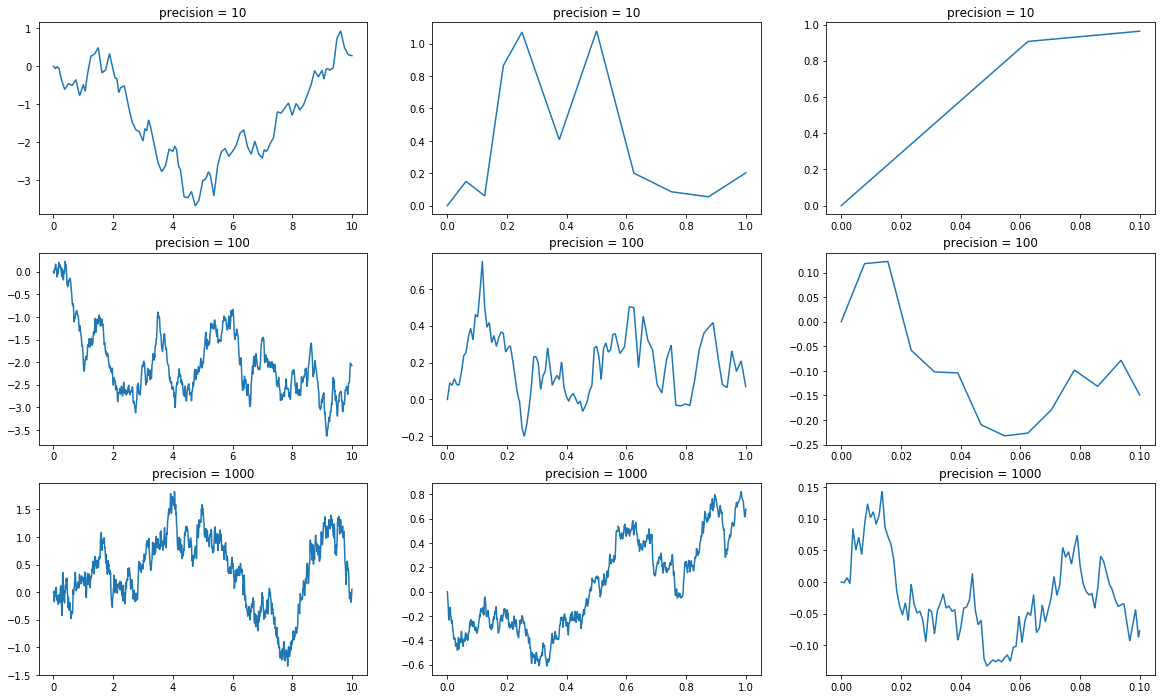

In [44]:
plt.figure(figsize=(20, 12))
for i, precision in enumerate([10, 100, 1000]):
    for j, max_time in enumerate([10, 1, 0.1]):
        t = np.linspace(0, max_time, 1000)
        values = WinerProcess(precision=precision)[t]
        
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.plot(t, values)
        plt.title('precision = %d' % precision)
plt.show()

Какие выводы можно сделать про каждый способ генерации?

...

Сравните два способа генерации по времени работы.

In [32]:
%time times, values = winer_proccess_path(100000, 0.1)

CPU times: user 2min 51s, sys: 16 ms, total: 2min 51s
Wall time: 2min 51s


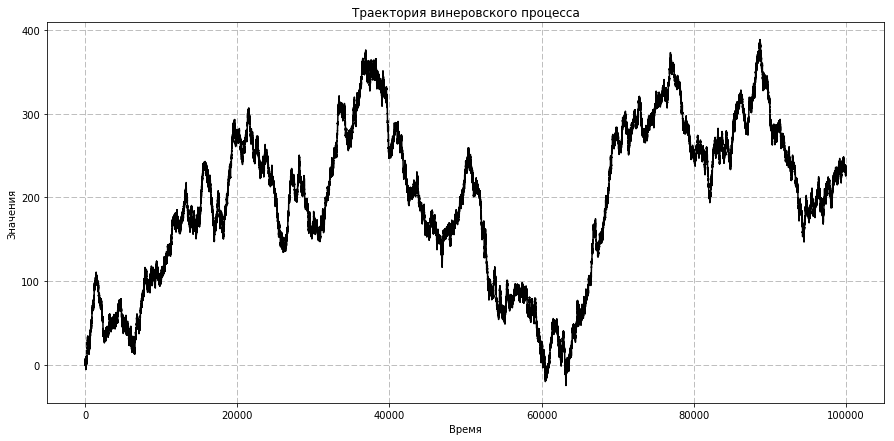

In [33]:
plt.figure(figsize=(15,7))

plt.plot(times, values, c='black')

plt.title('Траектория винеровского процесса')
plt.xlabel('Время')
plt.ylabel('Значения')
plt.grid(ls='--')
plt.show()

Постройте графики полученных траекторий для каждого способа? Отличаются ли траектории визуально?

Какие можно сделать выводы из сравнения двух способов генерации?

**Следующая часть работы делается индивидуально.**

1. Сгенерируйте 100 траекторий винеровского процесса с достаточно хорошей точностью и нарисуйте их на одном графике? Что можно сказать про поведение траекторий?

2. Нарисуйте график двумерного винеровского процесса (см. презентацию с семинара).

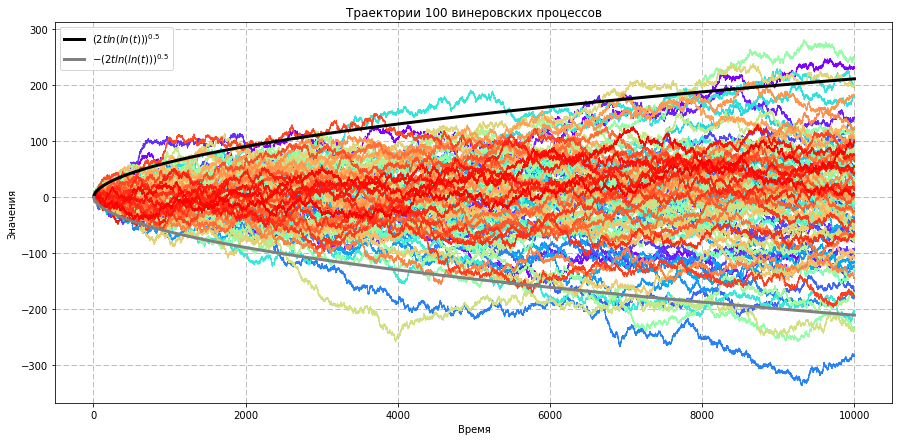

In [46]:
plt.figure(figsize=(15,7))
color = plt.cm.rainbow(np.linspace(0, 1, 100))
for i in range(100):
    times, values = winer_proccess_path(10000, 0.1)
    plt.plot(times, values, c=color[i], linewidth=1)
t = np.linspace(3, 10000, 100000)
plt.plot(t, np.sqrt(2*t*np.log(np.log(t))), c='black', linewidth=3, label=r'$(2tln(ln(t)))^{0.5}$')    
plt.plot(t, -np.sqrt(2*t*np.log(np.log(t))), c='grey', linewidth=3, label=r'$-(2tln(ln(t)))^{0.5}$')    

plt.title('Траектории 100 винеровских процессов')
plt.xlabel('Время')
plt.ylabel('Значения')
plt.grid(ls='--')
plt.legend()
plt.show()

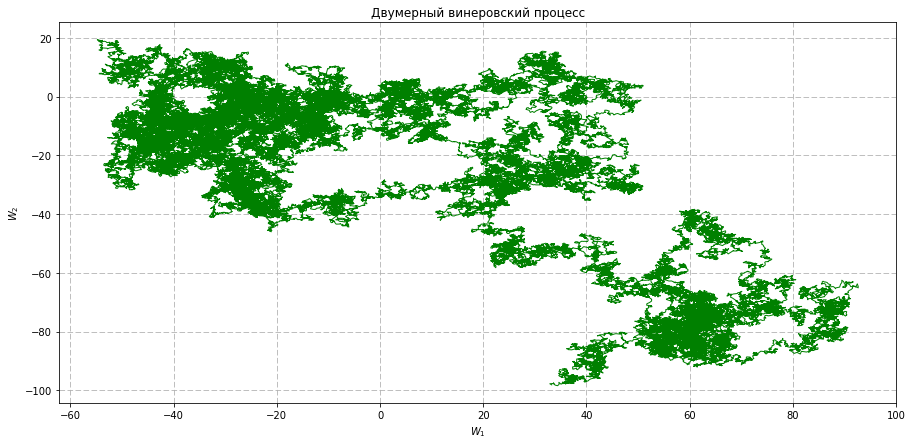

In [39]:
plt.figure(figsize=(15,7))

times, values1 = winer_proccess_path(10000, 0.1)
times, values2 = winer_proccess_path(10000, 0.1)
plt.plot(values1, values2, c='green', linewidth=1)


plt.title('Двумерный винеровский процесс')
plt.xlabel(r'$W_{1}$')
plt.ylabel(r'$W_{2}$')
plt.grid(ls='--')
plt.show()